In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
sys.path.append("/local/storage/ly349/projects/Deconvolution/Notebooks/")
from utils import get_bioqueue_job_info_ws

In [4]:
quality_level_remapping = {
    "HQ": "Excellent",
    "MQ": "Good",
    "LQ": "Acceptable",
}
plot_order = ("Acceptable", "Good", "Excellent")

In [5]:
eval_jobs = get_bioqueue_job_info_ws({"workspace": 131, "protocol": 317, "status": -1})
len(eval_jobs)

105

In [ ]:
csc_result_dfs = []

for j in eval_jobs:
    try:
        _items = j["job_name"].split("-")
        bulk_quality = _items[3]
        n_cell_str = _items[5]
    except:
        print(j["job_name"])
        break
    if bulk_quality not in quality_level_remapping.keys():
        continue
    n_cell = int(n_cell_str.split("D")[0])

    res_df = pd.read_csv(os.path.join(j["run_dir"], str(j["user_id"]), j["result"], f"{j['job_name']}.csc.csv.gz"))
    log_res_df = res_df.loc[res_df.Transform=="log"].copy()
    log_res_df["Experiment ID"] = n_cell_str
    log_res_df["Num cell types"] = n_cell
    log_res_df["Bulk quality"] = quality_level_remapping[bulk_quality]
    csc_result_dfs.append(log_res_df)
csc_result_df = pd.concat(csc_result_dfs, ignore_index=True)
csc_result_df.head()

,Model,Transform,Cluster,Corr coef,CCC,MSE,Experiment ID,Num cell types,Bulk quality
0,0,log,0,0.910870,0.906772,0.762394,9D3,9,Good
1,0,log,1,0.911927,0.911373,0.672096,9D3,9,Good
2,0,log,2,0.896051,0.892458,0.788619,9D3,9,Good
3,0,log,3,0.944250,0.938482,0.583255,9D3,9,Good
4,0,log,4,0.887026,0.884961,0.891229,9D3,9,Good


Acceptable y=-0.006x+0.956 -0.4658058050795969 3.548452807969559e-19 0.0006564528450322607
Good y=-0.006x+0.957 -0.4599326946322482 1.1174841049433972e-18 0.0006156212797014237
Excellent y=-0.006x+0.959 -0.48970921692370395 2.632757031044754e-21 0.000572542018846223


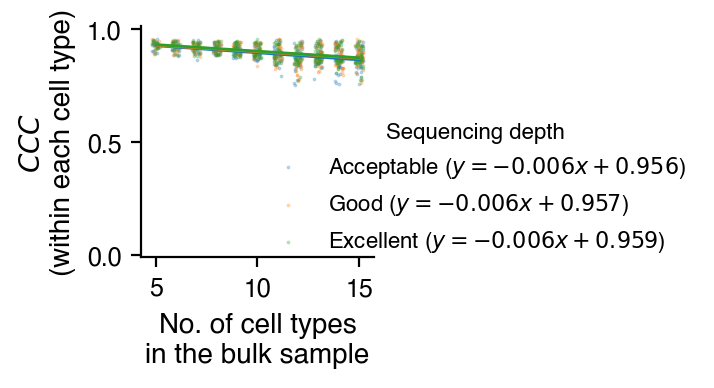

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
x_var = "Num cell types"
y_var = "CCC"
xrange = range(len(csc_result_df[x_var].unique()))
for quality in plot_order:
    sdf = csc_result_df.loc[csc_result_df["Bulk quality"]==quality]
    slope, intercept, r_value, pv, se = stats.linregress(sdf[x_var], sdf[y_var])
    print(quality, f"y={slope:.3f}x+{intercept:.3f}", r_value, pv, se)
    sns.regplot(
        x=x_var, y=y_var, data=sdf,
        scatter_kws={"s":0.8, "linewidths": 0.5, "alpha": 0.25}, 
        line_kws={"lw": 1}, x_jitter=0.2, ax=ax, label=fr"{quality} ($y={slope:.3f}x+{intercept:.3f}$)")

sns.despine()
ax.set_ylabel(r"$CCC$"+"\n(within each cell type)")
ax.set_xlabel("No. of cell types\nin the bulk sample")
ax.set_ylim((-0.01, 1.01))
plt.legend(title="Sequencing depth", title_fontsize=8, loc="center left", bbox_to_anchor=(0.45, 0.299))

In [ ]:
crc_result_dfs = []

for j in eval_jobs:
    try:
        _items = j["job_name"].split("-")
        bulk_quality = _items[3]
        n_cell_str = _items[5]
    except:
        print(j["job_name"])
        break
    if bulk_quality not in quality_level_remapping.keys():
        continue
    n_cell = int(n_cell_str.split("D")[0])

    res_df = pd.read_csv(os.path.join(j["run_dir"], str(j["user_id"]), j["result"], f"{j['job_name']}.crc.csv.gz"))
    log_res_df = res_df.loc[
        res_df.Transform=="log",
        ["Model", "CCC"]
        ].groupby("Model").agg("median")
    log_res_df["Experiment ID"] = n_cell_str
    log_res_df["Num cell types"] = n_cell
    log_res_df["Bulk quality"] = quality_level_remapping[bulk_quality]
    crc_result_dfs.append(log_res_df)
crc_result_df = pd.concat(crc_result_dfs, ignore_index=True)
crc_result_df.head()

,CCC,Experiment ID,Num cell types,Bulk quality
0,0.658136,9D3,9,Good
1,0.632270,9D2,9,Acceptable
2,0.689035,6D2,6,Good
3,0.665825,7D2,7,Acceptable
4,0.667997,9D2,9,Good


Acceptable y=-0.008x+0.716 -0.7714815229833 1.4769787597674508e-07 0.001184931132215987
Good y=-0.008x+0.733 -0.7921695041958099 3.965533227026868e-08 0.0010408997630458614
Excellent y=-0.008x+0.751 -0.8041234306950783 1.731238538549095e-08 0.0010282285205275284


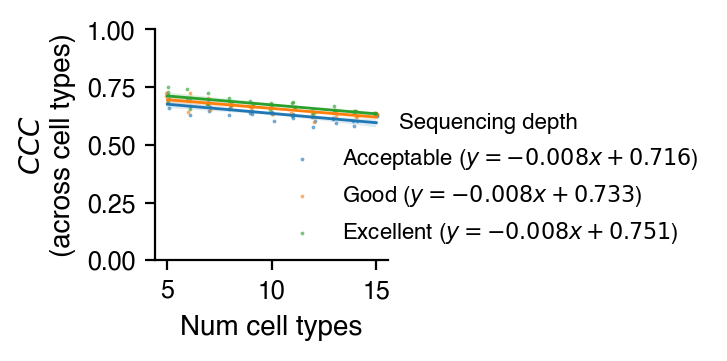

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
x_var = "Num cell types"
y_var = "CCC"

for quality in plot_order:
    sdf = crc_result_df.loc[crc_result_df["Bulk quality"]==quality]
    slope, intercept, r_value, pv, se = stats.linregress(sdf[x_var], sdf[y_var])
    print(quality, f"y={slope:.3f}x+{intercept:.3f}", r_value, pv, se)
    sns.regplot(
        x=x_var, y=y_var, data=sdf, 
        scatter_kws={"s":0.8, "linewidths": 0.5, "alpha": 0.5}, 
        line_kws={"lw": 1}, x_jitter=0.1, ax=ax, label=fr"{quality} ($y={slope:.3f}x+{intercept:.3f}$)")

sns.despine()
ax.set_ylabel(r"$CCC$"+"\n(across cell types)")
ax.set_ylim([0, 1])
plt.legend(title="Sequencing depth", title_fontsize=8, loc="center left", bbox_to_anchor=(0.45, 0.35))